In [2]:
import os
os.chdir("..")
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [66]:
with open("data/scenario_san_francisco.json") as f:
    data = json.loads(f.read())

In [67]:
df = pd.DataFrame(data["demand"])

# Simple summary stats

In [69]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [70]:
df_org_dest.head()

origin destination price           demand travel_time
                     count   mean      mean        mean
0      0           2    15  10.00  0.066667         4.0
1      0           8    15  46.40  0.066667        31.0
2      1           5    15  16.50  0.133333        10.0
3      1           7    30  31.95  0.066667        18.5
4      2           0    15  10.50  0.066667         5.0

In [71]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["Origin", "Destination", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [72]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price
count,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000
mean,1230.296089,6.237430,5.737430,0.385661,11.977654,18.692179
std,51.039938,2.014673,2.372853,0.496670,5.371075,8.274623
min,1140.000000,0.000000,0.000000,0.066667,3.000000,10.000000
25%,1186.000000,5.000000,4.000000,0.066667,9.000000,12.800000
50%,1232.000000,7.000000,6.000000,0.133333,11.000000,15.700000
75%,1273.000000,8.000000,8.000000,0.466667,15.000000,22.700000
max,1319.000000,9.000000,9.000000,2.333333,55.000000,69.400000


In [73]:
print(f"Origin nodes: {np.sort(df.origin.unique())}")
print(f"Destination nodes: {np.sort(df.destination.unique())}")

Origin nodes: [0 1 2 3 4 5 6 7 8 9]
Destination nodes: [0 1 2 3 4 5 6 7 8 9]


# Grid analysis

In [74]:
pivot_df = df_org_dest.pivot(index='Origin', columns='Destination', values='count').T
pivot_df = pivot_df

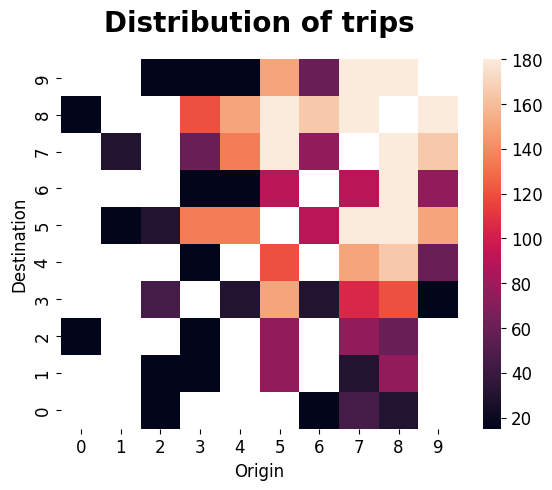

In [75]:
sns.heatmap(pivot_df.iloc[::-1], annot=False, fmt="d")
plt.title('Distribution of trips')
plt.xlabel(pivot_df.columns.name)
plt.ylabel(pivot_df.index.name)
plt.show()

In [76]:
mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(1,pivot_df.shape[1])

In [77]:
mean_demand_matrix

array([[0.06666667, 0.08888889, 0.06666667, 0.07948718, 0.12291667,
        0.39411765, 0.12413793, 0.36811594, 0.75641026, 0.37984496]])

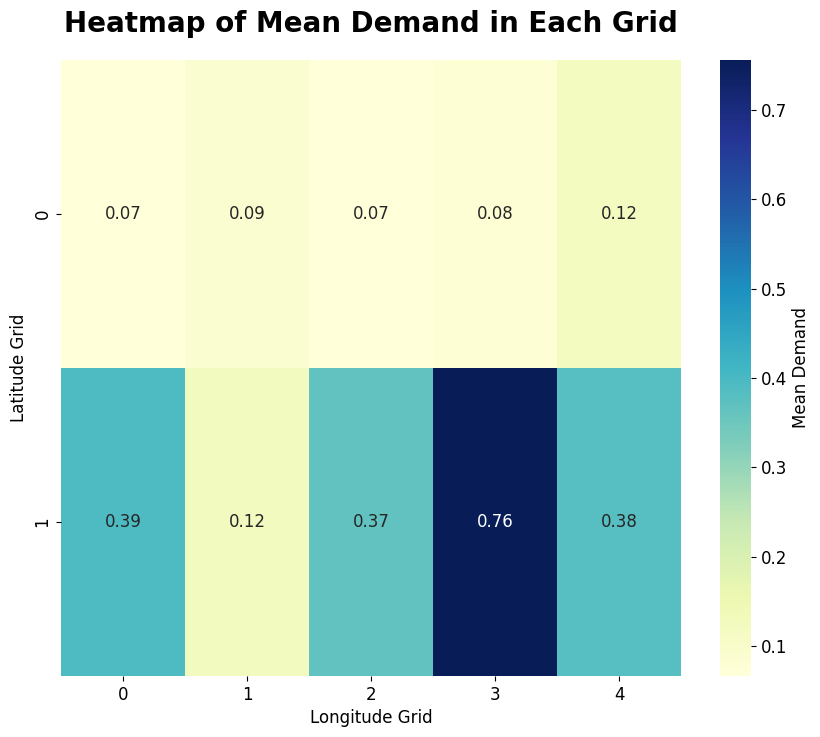

In [81]:
plt.figure(figsize=(10, 8))
sns.heatmap(mean_demand_matrix.reshape(2,5), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
plt.title('Heatmap of Mean Demand in Each Grid')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.show()

# Travel time analysis

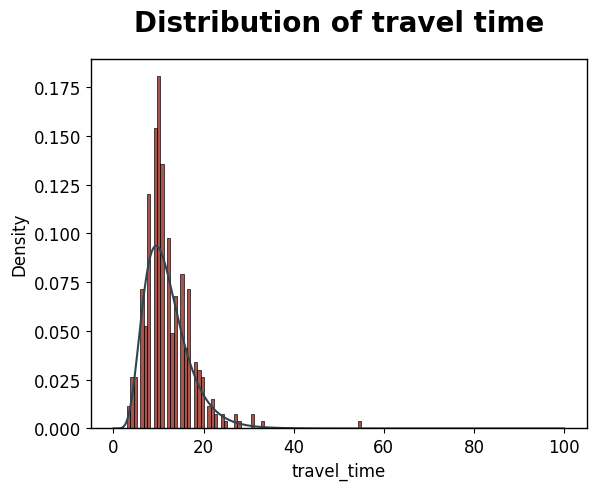

In [84]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of travel time")
plt.show()

# Price analysis

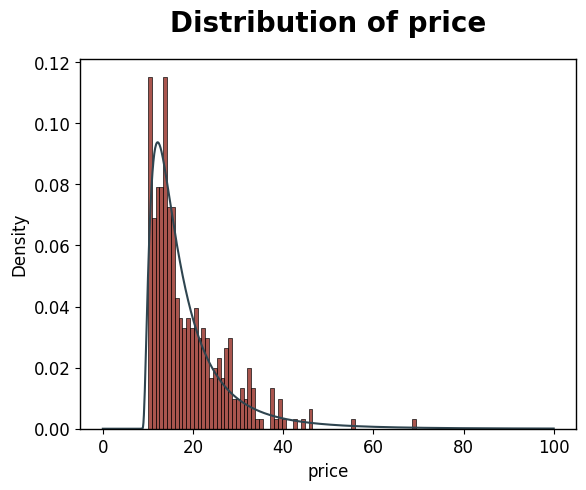

In [85]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of price")
plt.show()

In [86]:
pred_df = df.copy()

In [87]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

In [88]:
glm_model = smf.glm(formula="price ~ travel_time + demand", data=pred_df, family=sm.families.Gaussian())

In [89]:
fitted_glm = glm_model.fit()

In [90]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                 5370
Model:                            GLM   Df Residuals:                     5367
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          5.4822
Method:                          IRLS   Log-Likelihood:                -12187.
Date:                Fri, 17 Nov 2023   Deviance:                       29423.
Time:                        11:34:41   Pearson chi2:                 2.94e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.7884      0.086     32.607      0.000       2.621       2.956
travel_time     1.4190      0.006    236.288      0.000       1.407       1.431
demand         -2.8327      0.065    -43.619      0.000      -2.960      -2.705
===============================================================================
"""

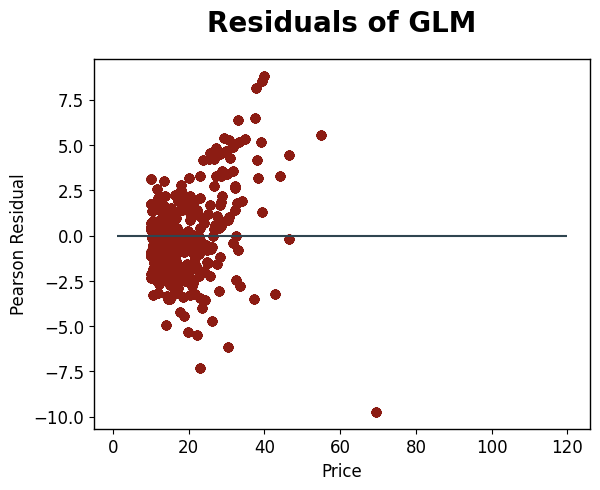

In [91]:
plt.scatter(pred_df["price"], pred_df["price"] - fitted_glm.predict())
plt.hlines(y=0, xmin=1, xmax=120, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.title("Residuals of GLM")
plt.show()